In [256]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


Поскольку при чтении csv файлов через pandas возникает ошибка, напишем свою функцию для чтения и преобразования данных при помощи csv модуля

In [295]:
def get_table(path):

    """
    Функция принимает на вход путь к таблице, считывает его построчно, фильтрует уникальные значения и создает из них датафрейм.
    Колонки именуются по первой строке, на выход подается датафрейм.
    """
    
    table_list = []
    
    with open(path, 'r') as file:
        my_reader = csv.reader(file, delimiter='|')
        for row in my_reader:
            table_list.append(list(dict.fromkeys(row)))
            
    table = pd.DataFrame(table_list)
    table.rename(columns=table.iloc[0], inplace = True)
    table.drop(table.index[0], inplace = True)
    
    return table.iloc[:, :5]

In [296]:
def join_tables(paths):

    """
    Функция принимает на вход пути к таблицам, возвращает слитую таблицу, обработанную через get_table
    """
    
    tables = []
    
    for path in paths:
        tables.append(get_table(path))
        
    return pd.concat(tables)

SyntaxError: EOF while scanning triple-quoted string literal (3587194811.py, line 10)

In [54]:
paths = ['/Users/alina/Downloads/data_task/file_1.csv',
         '/Users/alina/Downloads/data_task/file_2.csv',
         '/Users/alina/Downloads/data_task/file_3.csv',
         '/Users/alina/Downloads/data_task/file_4.csv']

В данных периодически возникают строки, которые некорректно считываются из-за дубликатов исходного текста в строке. Подобных данных примерно
12%. Попытаемся очистить их, сохранив данные максимально. Будем находить дубликаты и сдвигать ряды датафрейма, чтобы правильно считанные данные были разбиты по колонкам, дубликаты текстов и несчитанные данные опустим. 

In [297]:
def clear_duplicates(table):

    """
    Функция проверяет соседние значения датафрейма на предмет дубликатов текста, удаляет дубликат и сдвигает строку.
    """

    
    try:
        for i in range(len(table)):
            if table[table.columns[2]].iloc[i][:10] == table[table.columns[3]].iloc[i][:10]:
        
                table[table.columns[3]].iloc[i] = table[table.columns[4]].iloc[i]

            if table[table.columns[1]].iloc[i][:10] == table[table.columns[2]].iloc[i][:10]:
    
                table[table.columns[2]].iloc[i] = table[table.columns[3]].iloc[i]
                table[table.columns[3]].iloc[i] = table[table.columns[4]].iloc[i]
                
            if table[table.columns[0]].iloc[i][:10] == table[table.columns[1]].iloc[i][:10]:
                
                table[table.columns[1]].iloc[i] = table[table.columns[2]].iloc[i]
                table[table.columns[2]].iloc[i] = table[table.columns[3]].iloc[i]
                table[table.columns[3]].iloc[i] = table[table.columns[4]].iloc[i]
        
    except:
        pass
    return table

SyntaxError: EOF while scanning triple-quoted string literal (444831691.py, line 25)

In [298]:
merged_tables = join_tables(paths)

In [234]:
tables = clear_duplicates(merged_tables)

In [227]:
tables

,﻿text,sentence,aspect (group),sentiment,tone
1,Raise your hand if you think it's fine to go w...,"#T#, for example, brought an 80-minute scan d...",Kaspersky Security Cloud Free,positive,
2,Raise your hand if you think it's fine to go w...,#T# and Norton both have an aggregate score o...,Kaspersky,neutral,
3,Raise your hand if you think it's fine to go w...,#T# reserves its similar feature for the full...,Kaspersky,neutral,
4,Raise your hand if you think it's fine to go w...,Kaspersky reserves its similar feature for th...,Kaspersky Internet Security,neutral,
5,Raise your hand if you think it's fine to go w...,#T# gets fantastic lab scores and includes so...,Kaspersky Security Cloud Free,positive,
...,...,...,...,...,...
354,Working alongside the complimentary Office 365...,To help companies ensure the security of remo...,Kaspersky,positive,positive
355,Working alongside the complimentary Office 365...,#T# found that 186 million malicious spam mes...,Kaspersky research,positive,
356,Working alongside the complimentary Office 365...,"During January and February 2020, #T# blocked...",Kaspersky Security for Microsoft Office 365,positive,
357,Working alongside the complimentary Office 365...,"In order to reduce exposure to other threats,...",Kaspersky Security for Microsoft Office 365,positive,


In [315]:
import ast
import json
import re
import collections, functools, operator

import nltk
from nltk import tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/alina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Проверим датасет на наличие пустых значений. Видим, что пустых значений нет, но в датасете видны пустые строки, преимущественно на столбце tone

In [216]:
tables.isna().sum()

﻿text             0
sentence          0
aspect (group)    0
sentiment         0
tone              1
dtype: int64

In [223]:
tables.shape

(1177, 5)

In [221]:
len(tables[tables['tone'] == ''])

1085

Непустых начений столбца tone около 8%, значит для первичного анализа этот столбец можно опустить. Стоит оговориться, что там содержатся
уточнения по тону сообщения: если в сентимент-анализе данные классифицированы только по 3-м категориям, то в tone содержатся более детальные описания, но их слишком мало, чтобы делать выводы о данных.

In [235]:
tables = tables[tables.columns[:4]]

In [229]:
tables

,﻿text,sentence,aspect (group),sentiment
1,Raise your hand if you think it's fine to go w...,"#T#, for example, brought an 80-minute scan d...",Kaspersky Security Cloud Free,positive
2,Raise your hand if you think it's fine to go w...,#T# and Norton both have an aggregate score o...,Kaspersky,neutral
3,Raise your hand if you think it's fine to go w...,#T# reserves its similar feature for the full...,Kaspersky,neutral
4,Raise your hand if you think it's fine to go w...,Kaspersky reserves its similar feature for th...,Kaspersky Internet Security,neutral
5,Raise your hand if you think it's fine to go w...,#T# gets fantastic lab scores and includes so...,Kaspersky Security Cloud Free,positive
...,...,...,...,...
354,Working alongside the complimentary Office 365...,To help companies ensure the security of remo...,Kaspersky,positive
355,Working alongside the complimentary Office 365...,#T# found that 186 million malicious spam mes...,Kaspersky research,positive
356,Working alongside the complimentary Office 365...,"During January and February 2020, #T# blocked...",Kaspersky Security for Microsoft Office 365,positive
357,Working alongside the complimentary Office 365...,"In order to reduce exposure to other threats,...",Kaspersky Security for Microsoft Office 365,positive


Проверим строки на наличие дубликатов:

In [236]:
tables.loc[tables.duplicated()]

,﻿text,sentence,aspect (group),sentiment


Дубликатов нет, причем даже исходные тексты не считываются как дубликаты. Для последующего анализа оставим их.

In [237]:
tables

,﻿text,sentence,aspect (group),sentiment
1,Raise your hand if you think it's fine to go w...,"#T#, for example, brought an 80-minute scan d...",Kaspersky Security Cloud Free,positive
2,Raise your hand if you think it's fine to go w...,#T# and Norton both have an aggregate score o...,Kaspersky,neutral
3,Raise your hand if you think it's fine to go w...,#T# reserves its similar feature for the full...,Kaspersky,neutral
4,Raise your hand if you think it's fine to go w...,Kaspersky reserves its similar feature for th...,Kaspersky Internet Security,neutral
5,Raise your hand if you think it's fine to go w...,#T# gets fantastic lab scores and includes so...,Kaspersky Security Cloud Free,positive
...,...,...,...,...
354,Working alongside the complimentary Office 365...,To help companies ensure the security of remo...,Kaspersky,positive
355,Working alongside the complimentary Office 365...,#T# found that 186 million malicious spam mes...,Kaspersky research,positive
356,Working alongside the complimentary Office 365...,"During January and February 2020, #T# blocked...",Kaspersky Security for Microsoft Office 365,positive
357,Working alongside the complimentary Office 365...,"In order to reduce exposure to other threats,...",Kaspersky Security for Microsoft Office 365,positive


In [239]:
# Создадим информационный датасет для хранения статистики о текстовых данных

tables_info = pd.DataFrame()

# Определим функцию подсчета слов

def word_count(text):
    text_list = text.split()
    return len(text_list)

In [302]:
unique_texts = tables.drop_duplicates(subset=[tables.columns[0]])

In [303]:
unique_texts

,﻿text,sentence,aspect (group),sentiment
1,Raise your hand if you think it's fine to go w...,"#T#, for example, brought an 80-minute scan d...",Kaspersky Security Cloud Free,positive
2,Raise your hand if you think it's fine to go w...,#T# and Norton both have an aggregate score o...,Kaspersky,neutral
3,Raise your hand if you think it's fine to go w...,#T# reserves its similar feature for the full...,Kaspersky,neutral
4,Raise your hand if you think it's fine to go w...,Kaspersky reserves its similar feature for th...,Kaspersky Internet Security,neutral
5,Raise your hand if you think it's fine to go w...,#T# gets fantastic lab scores and includes so...,Kaspersky Security Cloud Free,positive
...,...,...,...,...
354,Working alongside the complimentary Office 365...,To help companies ensure the security of remo...,Kaspersky,positive
355,Working alongside the complimentary Office 365...,#T# found that 186 million malicious spam mes...,Kaspersky research,positive
356,Working alongside the complimentary Office 365...,"During January and February 2020, #T# blocked...",Kaspersky Security for Microsoft Office 365,positive
357,Working alongside the complimentary Office 365...,"In order to reduce exposure to other threats,...",Kaspersky Security for Microsoft Office 365,positive


In [307]:
# Для исходных текстов
# Подсчитаем длину текста в символах, число слов в тексте, среднюю длину слова в тексте

# Для классифицируемых предложений посчитаем те же показатели

# Укажем усредненные показатели по датасету


tables_info['text_length'] = tables[tables.columns[0]].str.len()
tables_info['text_word_count'] = tables[tables.columns[0]].apply(word_count)
tables_info['text_mean_word_length'] = tables[tables.columns[0]].map(lambda text: np.mean([len(word) for word in text.split()]))

tables_info['sent_length'] = tables['sentence'].str.len()
tables_info['sent_word_count'] = tables['sentence'].apply(word_count)
tables_info['sent_mean_word_length'] = tables['sentence'].map(lambda text: np.mean([len(word) for word in text.split()]))

print("Среднее число символов в тексте: ", tables_info['text_length'].mean())
print("Среднее число слов в тексте: ", tables_info['text_word_count'].mean())
print("Средняя длина слов в тексте: ", tables_info['text_mean_word_length'].mean())

print("Среднее число символов в предложении: ", tables_info['sent_length'].mean())
print("Среднее число слов в предложении: ", tables_info['sent_word_count'].mean())
print("Средняя длина слов в предложении: ", tables_info['sent_mean_word_length'].mean())


Среднее число символов в тексте:  4851.85471537808
Среднее число слов в тексте:  765.3101104502973
Средняя длина слов в тексте:  5.420638147069096
Среднее число символов в предложении:  193.0339847068819
Среднее число слов в предложении:  30.4035683942226
Средняя длина слов в предложении:  5.332598379771948


Видим, что исходные тексты в целом очень большие, поэтому впоследствии классифицировать целые тексты будем проблематично (затратно по ресурсам, + очень малое количество моделей, особенно поддерживающих русский язык, можеть принять на вход такой длинный текстовый промт).

Предложения, наоборот, довольно удобны для анализа по длине, значит впоследствии более подробный анализ (например, уточнение tone) не будет проблематичным.

Посмотрим на возможные выбросы:

In [246]:
print("Минимальное число знаков в тексте: ", min(tables_info['text_length']))
print("Минимальное количество слов в тексте: ", min(tables_info['text_word_count']))
print("Минимальная длина слов в тексте: ", min(tables_info['text_mean_word_length']))

print("Минимальное число символов в предложении: ", min(tables_info['sent_length']))
print("Минимальное число слов в предложении: ", min(tables_info['sent_word_count']))
print("Минимальная длина слов в предложении: ", min(tables_info['sent_mean_word_length']))

Минимальное число знаков в названии:  808
Минимальное количество слов в названии:  134
Минимальная длина слов в названии:  4.5550249169435215
Минимальное число символов в предложении:  5
Минимальное число слов в предложении:  1
Минимальная длина слов в предложении:  3.4285714285714284


У текстов выбросов нет, а у предложений - есть. Посмотрим на них:

In [309]:
tables.loc[tables_info['sent_word_count'] < 3]

,﻿text,sentence,aspect (group),sentiment
164,"""This, as a single tactic, would not be suffic...",#T#.,Eugene Kaspersky,neutral
145,(Source – Kaspersky)Phishing emails are a big ...,Dashveenjit Kaur,"21 April, 2022According to data by #T#, a tot...",Kaspersky
149,(Source – Kaspersky)Phishing emails are a big ...,Kaspersky,neutral,
215,"Just during the last week, there were about 30...",Kaspersky,positive,


Видим один реальный выброс (1 слово в предложении), остальное - некорректно считанные данные.

Выбросы в контексте максимальных значений:

In [310]:
print("Максимальное число знаков в тексте: ", max(tables_info['text_length']))
print("Максимальное количество слов в тексте: ", max(tables_info['text_word_count']))
print("Максимальная длина слов в тексте: ", max(tables_info['text_mean_word_length']))

print("Максимальное число символов в предложении: ", max(tables_info['sent_length']))
print("Максимальное число слов в предложении: ", max(tables_info['sent_word_count']))
print("Максимальная длина слов в предложении: ", max(tables_info['sent_mean_word_length']))

Максимальное число знаков в тексте:  26759
Максимальное количество слов в тексте:  4817
Максимальная длина слов в тексте:  6.3624161073825505
Максимальное число символов в предложении:  7284
Максимальное число слов в предложении:  1152
Максимальная длина слов в предложении:  9.0


Есть непомерно длинные (и сложные для обработки, как следствие) тексты, и есть выбросы среди предложений. Если их предстоит анализировать в дальнейшем, лучше будет предложения с такими большими значениями убрать. Но это могут быть так же единично некорректно считанные данные.

In [311]:
tables.loc[tables_info['sent_word_count'] >= 1000]

,﻿text,sentence,aspect (group),sentiment
99,"#T#, founder of Kaspersky Labs. (Photo: Getty)...","Eugene Kaspersky, founder of #T# Labs.|Kaspers...",(Photo: Getty) Products by the security softw...,Kaspersky Lab
347,#T# has named former Symantec executive Christ...,Anonymized data voluntarily provided by #T# cu...,In all three finance categories during the sa...,Kaspersky


Таких выбросов мало (ими можно свободно пренебречь), и также это скорее всего действительно некорректно считанные данные

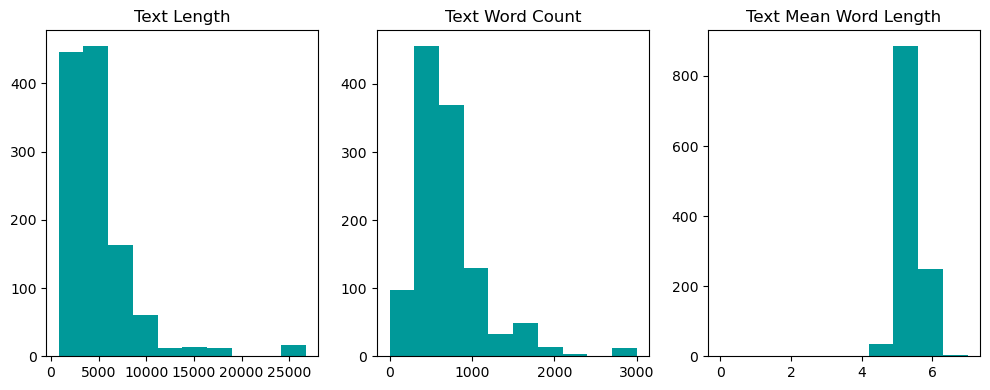

In [273]:
# Проиллюстрируем найденные показатели

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax0.hist(tables_info['text_length'], histtype='bar', color='#009999')
ax0.set_title('Text Length')

ax1.hist(tables_info['text_word_count'], range=[0, 3000], histtype='bar', color='#009999' )
ax1.set_title('Text Word Count')

ax2.hist(tables_info['text_mean_word_length'],  range=[0, 7], histtype='bar', color='#009999')
ax2.set_title('Text Mean Word Length')

fig.tight_layout()
plt.show()

Тексты очень однородны сами по себе. Скорее всего, сказывается тот факт, что в данных очень много идентичных текстов, и уникальных значений гораздо меньше

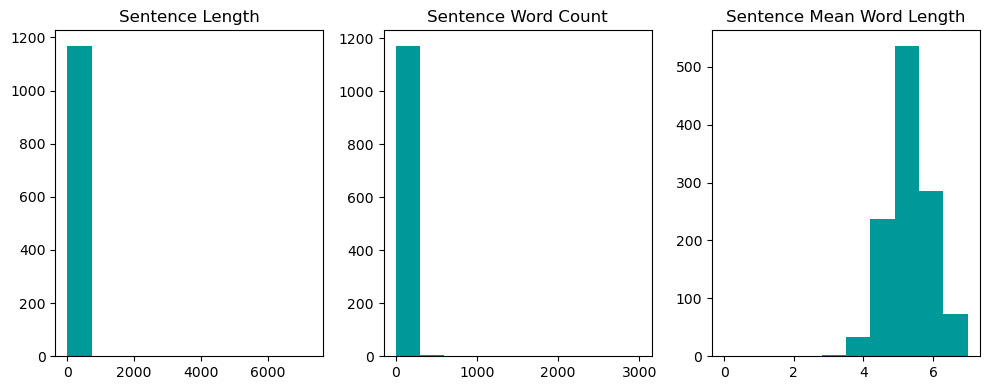

In [312]:
# Проиллюстрируем найденные показатели

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax0.hist(tables_info['sent_length'], histtype='bar', color='#009999')
ax0.set_title('Sentence Length')

ax1.hist(tables_info['sent_word_count'], range=[0, 3000], histtype='bar', color='#009999' )
ax1.set_title('Sentence Word Count')

ax2.hist(tables_info['sent_mean_word_length'],  range=[0, 7], histtype='bar', color='#009999')
ax2.set_title('Sentence Mean Word Length')

fig.tight_layout()
plt.show()

Предложения тоже очень однородны, что удобно для анализа. Посмотрим на распределение длин предложений по классам (возможно, это дополнительная фича для классификации окажется):

Text(0.5, 1.0, 'Distribution of classes by Length')

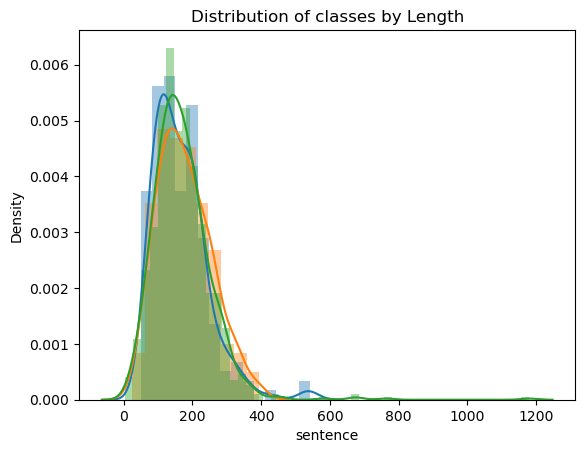

In [293]:
pos = tables[tables['sentiment'] == 'positive']['sentence'].str.len()
sns.distplot(pos, label='Positive')

neg = tables[tables['sentiment'] == 'negative']['sentence'].str.len()
sns.distplot(neg, label='Negative')

neut = tables[tables['sentiment'] == 'neutral']['sentence'].str.len()
sns.distplot(neut, label='Neutral')

plt.title('Distribution of classes by Length')

Но внутри классов предложения так же очень однородны. По количеству слов наблюдаем такое же распределение

Text(0.5, 1.0, 'Distribution of classes by Word Count')

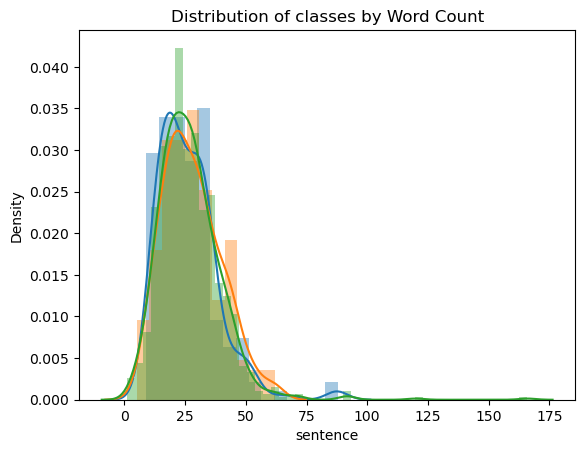

In [313]:
pos = tables[tables['sentiment'] == 'positive']['sentence'].apply(word_count)
sns.distplot(pos, label='Positive')

neg = tables[tables['sentiment'] == 'negative']['sentence'].apply(word_count)
sns.distplot(neg, label='Negative')

neut = tables[tables['sentiment'] == 'neutral']['sentence'].apply(word_count)
sns.distplot(neut, label='Neutral')

plt.title('Distribution of classes by Word Count')

Анализ частотности для классов и исходных предложений:

In [316]:
# Небольшой препроцессинг текста: перевод символов в нижний регистр, токенизация, удаление стоп-слов, включая частотные для нашего датасета

tfa_sents_overall = tables['sentence']

stopwords = stopwords.words("english")

In [317]:
tfa_sents_tokenized =tfa_sents_overall.apply(lambda s: nltk.word_tokenize(s))
tfa_sents_preprocessed = tfa_sents_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_sents_clean = tfa_sents_preprocessed.apply(lambda str: [w for w in str if w not in stopwords])

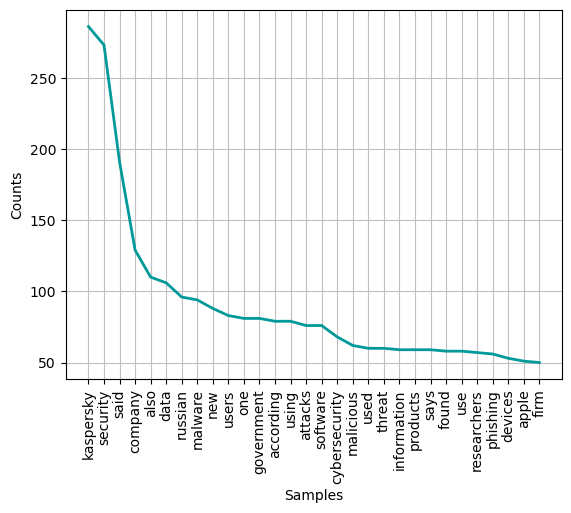

<Axes: xlabel='Samples', ylabel='Counts'>

In [318]:
# Иллюстрация

tfa_sents_merged = []
for word_list in tfa_sents_clean:
    tfa_sents_merged += word_list
fdist = FreqDist(tfa_sents_merged)
fdist.plot(30,cumulative=False, color = '#009999')

Из этого распределения можно сделать вывод о примерном содержании текстов - кибербезопасность, политика, новости мира электроники
Посмотрим на внутриклассовые распределения

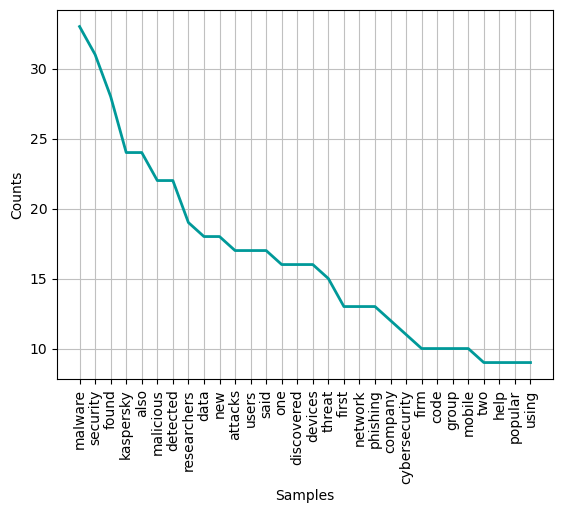

<Axes: xlabel='Samples', ylabel='Counts'>

In [319]:
tfa_pos_overall = tables['sentence'].loc[tables['sentiment'] == 'positive']

tfa_pos_tokenized =tfa_pos_overall.apply(lambda s: nltk.word_tokenize(s))
tfa_pos_preprocessed = tfa_pos_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_pos_clean = tfa_pos_preprocessed.apply(lambda str: [w for w in str if w not in stopwords])

tfa_pos_merged = []

for word_list in tfa_pos_clean:
    tfa_pos_merged += word_list
fdist = FreqDist(tfa_pos_merged)

fdist.plot(30,cumulative=False, color = '#009999')

Позитивные предложения содержат в большинстве своем упоминания о безопасности, о детектированной угрозе, о положительном открытии, нововведении, новой технологии

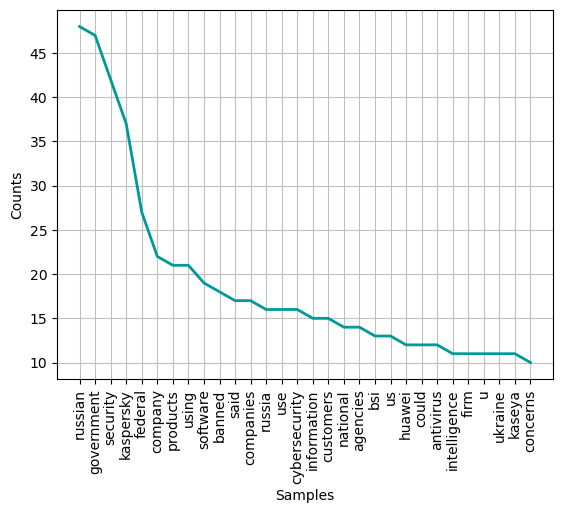

<Axes: xlabel='Samples', ylabel='Counts'>

In [286]:
tfa_neg_overall = tables['sentence'].loc[tables['sentiment'] == 'negative']

tfa_neg_tokenized =tfa_neg_overall.apply(lambda s: nltk.word_tokenize(s))
tfa_neg_preprocessed = tfa_neg_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_neg_clean = tfa_neg_preprocessed.apply(lambda str: [w for w in str if w not in stopwords])

tfa_neg_merged = []

for word_list in tfa_neg_clean:
    tfa_neg_merged += word_list
fdist = FreqDist(tfa_neg_merged)

fdist.plot(30,cumulative=False, color = '#009999')

Отрицательно окрашенные предложения относятся чаще всего к политике, запретам, нарушениям безопасности

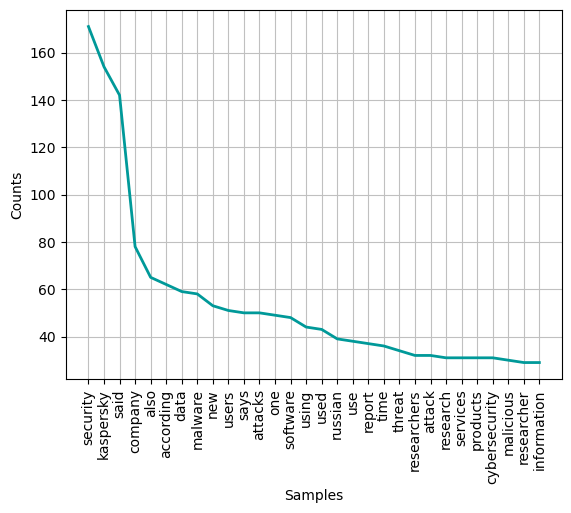

<Axes: xlabel='Samples', ylabel='Counts'>

In [287]:
tfa_neut_overall = tables['sentence'].loc[tables['sentiment'] == 'neutral']

tfa_neut_tokenized =tfa_neut_overall.apply(lambda s: nltk.word_tokenize(s))
tfa_neut_preprocessed = tfa_neut_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_neut_clean = tfa_neut_preprocessed.apply(lambda str: [w for w in str if w not in stopwords])

tfa_neut_merged = []

for word_list in tfa_neut_clean:
    tfa_neut_merged += word_list
    
fdist = FreqDist(tfa_neut_merged)

fdist.plot(30,cumulative=False, color = '#009999')

Нейтральные сообщения совпадают в распределении с предложениями в общем плане. Вероятно, нейтральный класс доминирует над позитивным и негативным

([<matplotlib.patches.Wedge at 0x16e4ae580>,
 [Text(0.9741077310696443, 0.510993276149843, 'positive'),
  Text(0.18613811392300614, 1.0841368006599472, 'negative'),
  Text(-0.6684591831020508, -0.873591621140301, 'neutral')])

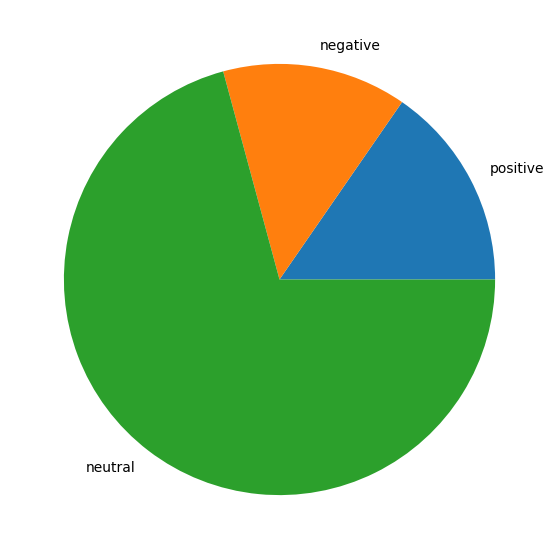

In [320]:
class_distribution = [len(tables.loc[tables['sentiment'] == 'positive']),
                        len(tables.loc[tables['sentiment'] == 'negative']),
                        len(tables.loc[tables['sentiment'] == 'neutral'])]

class_labels = ['positive', 'negative', 'neutral']

fig = plt.figure(figsize=(10, 7))
plt.pie(class_distribution, labels=class_labels)

Так и есть

В датасете представлены новости/публичные высказывания с соответствующей им коннотацией (позитивная, негативная, нейтральная)

Какую задачу можно решить при помощи этих данных?

1. Модерация новостей, комментариев
2. Коррекция формулировок публикаций или публичных выступлений (конкретно классификация отдельных предложений этому способствует)
3. Отделить объективную критику компании в сети (то, что можно улучшить), от необоснованных негативных высказываний
4. Предсказание отклика, который вызовут те или иные новости, и возможность предпринять те или иные действия (усиленная модерация, закрытие комментариев к новости, повышенное внимание к новости), подготовиться к потенциальному кризису, скандалу или инфоповоду
5. Инвесторы, политики, публичные личности могут совершать более обдуманные и дальновидные решения, зная, как публика отреагирует на новость
6. Фильтрация контета для обучения моделей

Если говорить о подобном методе анализа в отрыве от выбранного типа контента (новостей), можно расширить круг применения данной классификации:

7. Улучшить клиентскую поддержку, классифицируя запросы клиентов и подбирая соответствующих сотрудников/автоматические ответы бота поддержки
8. Уделять большее внимание негативным отзывам о продукте (находить их и выяснять, чем было вызвано недовольство, что следует исправить в экстренном порядке)
9. Фильтровать отзывы/комментарии нецензурного содержания 
